# Exercises Day04

In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy 
import matplotlib.pyplot as plt
from helper_functions import *

def normpdf(x : float, mu : float, sigma : float) -> float:
    """
        Normal distribution probability density function.
        
        :param x: x value
        :param mu: mean
        :param sigma: standard deviation
        
        :return: probability density function value
    """
    return 1/(np.sqrt(2 * np.pi) * sigma) * np.exp(-1.0 / 2 * ((mu - x) / sigma)**2)

def compute_confidence_interval_sample(data : list[float], confidence : float = 0.95, normal : bool = False ) -> list[float]:
    """
        Compute the confidence interval of the mean of the data.
        :param data: list of data
        :param confidence: confidence level
        :param normal: whether of not the data is assumed normal distributed
        
        :return: confidence interval of the mean of the data
    """
    N = len(data)
    alpha = 1 - confidence

    data = np.array(data)
    if normal:
        conf_mean = [data.mean() + data.std()/np.sqrt(N) * scipy.stats.t.cdf(alpha/2, N - 1), data.mean() + data.std()/np.sqrt(N) * scipy.stats.t.cdf(1-alpha/2, N - 1)]
    else:
        conf_mean = [data.mean() - confidence * data.std()/np.sqrt(N), data.mean() + confidence * data.std()/np.sqrt(N)]
    
    return conf_mean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ex01

**Estimate an integral $\int_0^1 e^x d x$ by simulation (the Crude Monte Carlo estimator). Use e.g. an estimator based on 100 samples and present the result as the point estimator and a confidence interval.**



In [65]:
# We assume that we may use numpy because we already went through with sampling from numpy once
# although you didn't explicitely state it as last time...
NUM_SAMPLES = 100

crude_monte_carlo = np.exp(np.random.uniform(0, 1, NUM_SAMPLES))
crude_mc_estimate = crude_monte_carlo.mean()
crude_mc_conf = compute_confidence_interval_sample(crude_monte_carlo)

print("Crude Monte Carlo (point) estimate: ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")
print(f"Crude Monte Carlo variance: {crude_monte_carlo.var():.4f}")

Crude Monte Carlo (point) estimate:  1.6580421468361097
Crude Monte Carlo confidence interval: [1.6144, 1.7017]
Crude Monte Carlo variance: 0.2114


## Ex02

**Estimate an integral $\int_0^1 e^x d x$ using antithetic variables, with comparable computer ressources.**

In [66]:
# Again we assume numpy is allowed :D

num_samples_antithetic = NUM_SAMPLES // 50  # <-- Going from crude to antithetic, reduces the variance by a factor of 50 (see slide 12 of 'slide7m1.pdf')

U = np.random.uniform(0, 1, NUM_SAMPLES)
X = np.exp(U)
Z = np.exp(1 - U)
Y = (X + Z) / 2

antithetic_estimate = Y.mean()
antithetic_conf = compute_confidence_interval_sample(Y)


print(f"Antithetic (point) estimate (with {num_samples_antithetic} samples): ", antithetic_estimate)
print(f"Antithetic confidence interval: [{antithetic_conf[0]:.4f}, {antithetic_conf[1]:.4f}]\n")
print(f"Crude Monte Carlo (point) estimate (with {NUM_SAMPLES} samples): ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")

Antithetic (point) estimate (with 2 samples):  1.7172882397118117
Antithetic confidence interval: [1.7113, 1.7233]

Crude Monte Carlo (point) estimate (with 100 samples):  1.6580421468361097
Crude Monte Carlo confidence interval: [1.6144, 1.7017]


## Ex03

**Estimate an integral $\int_0^1 e^x d x$ using a control variable, with comparable computer ressources.**


In [67]:
cov = lambda x,y: np.sum((x - x.mean()) * (y - y.mean())) / (len(x) - 1) 

num_samples_control = 100

U = np.random.uniform(0, 1, num_samples_control) # Here U = Y from slides 
X = np.exp(U)

c =  - cov(U, X) / U.var()

Z = X + c * (U - 0.5)

control_estimate = Z.mean()
control_conf = compute_confidence_interval_sample(Z)


print(f"Control sampling (point) estimate (with {num_samples_control} samples): ", control_estimate)
print(f"Antithetic confidence interval: [{control_conf[0]:.4f}, {control_conf[1]:.4f}]\n")

print(f"Crude Monte Carlo (point) estimate (with {NUM_SAMPLES} samples): ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")



Control sampling (point) estimate (with 100 samples):  1.7140216681069307
Antithetic confidence interval: [1.7081, 1.7199]

Crude Monte Carlo (point) estimate (with 100 samples):  1.6580421468361097
Crude Monte Carlo confidence interval: [1.6144, 1.7017]


## Ex04

**Estimate an integral $\int_0^1 e^x d x$ using stratified sampling, with
comparable computer ressources.**


In [68]:
num_samples_stratified = 10
m = 10

W = 0
for i in range(m):
    W += np.exp(np.random.uniform((1 / m) * i, (1 / m) * (i + 1), num_samples_stratified) / m + i/m)

W /= m

stratified_estimate = W.mean()
stratified_conf = compute_confidence_interval_sample(W)

print(f"Stratified sampling (point) estimate (with {num_samples_stratified * m} samples): ", stratified_estimate)
print(f"Stratified confidence interval: [{stratified_conf[0]:.4f}, {stratified_conf[1]:.4f}]\n")

print(f"Crude Monte Carlo (point) estimate (with {NUM_SAMPLES} samples): ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")

Stratified sampling (point) estimate (with 100 samples):  1.7327551236802101
Stratified confidence interval: [1.7322, 1.7333]

Crude Monte Carlo (point) estimate (with 100 samples):  1.6580421468361097
Crude Monte Carlo confidence interval: [1.6144, 1.7017]


## Ex05

**Use control variates to reduce the variance of the estimator in
exercise 04 (Poisson arrivals).**

$$
    \tilde{X} = X + c_1 ( \bar{X}_{arrival} - \frac{1}{\lambda})
$$

$X$ is here blocked rate (vector of all the samples), while $\bar{X}_{arrival}$ is the arrival rate (vector of all the arrival times) and $\frac{1}{\lambda}$ is the theoretical mean of arrivals rates.

In [69]:
block_fraction, arrivals = blocking_simulation()

block_fraction = np.array(block_fraction); arrivals = np.array(arrivals)
c = cov(block_fraction, arrivals) / arrivals.var()
X = block_fraction + c * (arrivals - ARRIVAL_MEAN) # <-- ARRIVAL_MEAN is defined in helperfunction.py


# exact 
A = ARRIVAL_MEAN * SERVICE_MEAN

B = (A**m / np.math.factorial(m)) / np.sum([(A**i) / np.math.factorial(i) for i in range(m+1)])

print(f"Orignal estimate: {block_fraction.mean():.5f} \tApplied control variates {X.mean():.5f} \tExact solution {B:.5f}")
print(f"Orignal estimate residual: {np.abs((block_fraction.mean() - B)):.5f} \tApplied control variates residual: {np.abs(X.mean() - B):.5f}")


run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
Orignal estimate: 0.12090 	Applied control variates 0.12010 	Exact solution 0.12166
Orignal estimate residual: 0.00076 	Applied control variates residual: 0.00156


## Ex06

**Demonstrate the effect of using common random numbers in exercise 4 for the difference between Poisson arrivals (Part 1) and a renewal process with hyperexponential interarrival times.**

*Remark: You might need to do some thinking and some re-programming* 



In [77]:
HYPER_MEAN

[1.2000480019200768, 0.2]

In [78]:
def sample_arrival_poisson_process_sampleU(U) -> float:
    """
        Sample the service time from an exponential distribution.
        
        :return: service time (as a float)
    """
    return -np.log(U)/(1/ARRIVAL_MEAN)


def sample_arrival_hyper_exponential(U) -> float:
    """
    """
    p = np.random.binomial(n=1,p= HYPER_PROB)

    if p:
        return -np.log(U)/(1/HYPER_MEAN[0])
    else:
        return -np.log(U)/(1/HYPER_MEAN[1])

U = np.random.uniform(0,1,(10,10001))

arrivals_sample_exp = sample_arrival_poisson_process_sampleU(U)
arrivals_sample_hexp = sample_arrival_hyper_exponential(U)


## Simulation
def blocking_simulation_sampleU(
    simulation_runs : int = 10,
    m : int = 10,
    N : int = 10000,
    sample_arrival :np.ndarray[np.ndarray[float]] = arrivals_sample_exp,
    sample_service_time : Callable[[], float] = sample_service_time_exponential
    ) -> tuple[list[float], list[float]]:
    """
        A function for runinng multiple simulations of a blocking system.
        
        :param simulation_runs: number of simulations to run
        :param m: number of service units
        :param N: number of customers
        :param sample_arrival: function for sampling arrival time
        :param sample_service_time: function for sampling service time
        
        :return: list of blocked fractions and list of average arrival times
    """
    # NOTE: Maybe use burn in period...?
    
    blocked_fractions = []
    arrival_times = []
    for i in range(simulation_runs):
        print(f"run {i+1}")
        custmer_count = 0
        global_time = 0
        event_counter = 0
        block_count = 0
        arrivals = 0


        # lists
        event_list = []
        service_units_status = [False for _ in range(m)]    # <-- Indicates whether the service units are occupied or not
        

        # First arrival
        first_arrival = sample_arrival[i,0]
        event_list.append(Event('arrival', global_time + first_arrival))
        arrivals += first_arrival
        
        global_time += first_arrival
        event_list.append(Event('departure', global_time + first_arrival))
        service_units_status[0] = True # <-- unit 1 is occupied

        while custmer_count < N:
            
            current_event = event_list[event_counter]

            # Increment global time
            global_time = current_event.time

            if current_event.event_type == 'arrival':
                custmer_count += 1

                # Check for free service units
                indx, available = check_available_service(service_units_status)
                
                if available:
                    # Insert departure event and depend to eventlist
                    
            
                    departure_event = Event('departure', global_time + sample_service_time())
                    event_list = apend_event(event_list, departure_event)

                    # Take service unit
                    service_units_status[indx] = True # <-- unit indx is occupied

                if not available:
                    # Costumer blocked
                    block_count += 1
                
                # insert time for next arrival
                new_arrival = sample_arrival[i,custmer_count]
                arrivals += new_arrival
                arrival_event = Event('arrival', global_time + new_arrival)
                event_list = apend_event(event_list, arrival_event)

            elif current_event.event_type == 'departure': 
                # Free the service unit for the current departure event
                for indx, unit_occupied in enumerate(service_units_status):
                    if unit_occupied:
                        service_units_status[indx] = False # <-- unit indx is free
                        break
                        
            # increment event counter
            event_counter += 1
        
        blocked_fractions.append(block_count / N)
        arrival_times.append(arrivals / N)
    
    return blocked_fractions, arrival_times


block_fraction_exp, _ = blocking_simulation_sampleU(sample_arrival = arrivals_sample_exp)
block_fraction_hexp, _ = blocking_simulation_sampleU(sample_arrival = arrivals_sample_hexp)

run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10


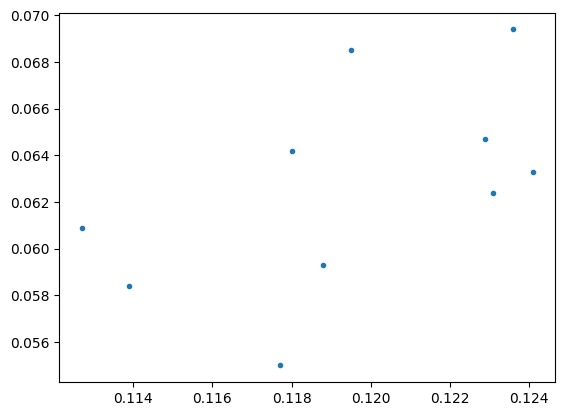

In [81]:

plt.figure()
plt.plot(block_fraction_exp,block_fraction_hexp,'.')
plt.show()

This has a overall increasing tendency. 

## Ex07

In [51]:
# Crude monte carlo? YES!
NUM_SAMPLES = [10**i for i in range(3,6)]

a_s = [2,3,4] # Try different values


def importance_sampling(a, num_samples: int,sigma2: float = 1):
    importance_samples = scipy.stats.norm.rvs(a, sigma2, num_samples)

    importance_h = importance_samples > a # Indicator function
    importance_f = scipy.stats.norm.pdf(importance_samples,0,1)
    importance_g = scipy.stats.norm.pdf(importance_samples,a,sigma2)

    importance_prob = np.mean((importance_h * importance_f) / importance_g)
    return importance_prob

probs = np.zeros((len(NUM_SAMPLES),len(a_s),3))
for i,num_samples in enumerate(NUM_SAMPLES):
    print(f"Number of samples: {num_samples}")
    for j, a in enumerate(a_s):
        print(f"\ta = {a}")

        analytic = 1-scipy.stats.norm.cdf(a,0,1)
        crude_monte_carlo = np.sum(np.random.normal(0, 1, num_samples)>a)/num_samples
        importance_prob = importance_sampling(a,num_samples)

        print(f"\t\tAnalytc solution : \t\t{analytic:.4f} \n\t\tMonte Carlo estimation: \t{crude_monte_carlo:.4f} \n\t\tImportance sampling estimation \t{importance_prob:.4f}\n")






Number of samples: 1000
	a = 2
		Analytc solution : 		0.0228 
		Monte Carlo estimation: 	0.0200 
		Importance sampling estimation 	0.0239

	a = 3
		Analytc solution : 		0.0013 
		Monte Carlo estimation: 	0.0000 
		Importance sampling estimation 	0.0014

	a = 4
		Analytc solution : 		0.0000 
		Monte Carlo estimation: 	0.0000 
		Importance sampling estimation 	0.0000

Number of samples: 10000
	a = 2
		Analytc solution : 		0.0228 
		Monte Carlo estimation: 	0.0228 
		Importance sampling estimation 	0.0231

	a = 3
		Analytc solution : 		0.0013 
		Monte Carlo estimation: 	0.0012 
		Importance sampling estimation 	0.0013

	a = 4
		Analytc solution : 		0.0000 
		Monte Carlo estimation: 	0.0002 
		Importance sampling estimation 	0.0000

Number of samples: 100000
	a = 2
		Analytc solution : 		0.0228 
		Monte Carlo estimation: 	0.0226 
		Importance sampling estimation 	0.0226

	a = 3
		Analytc solution : 		0.0013 
		Monte Carlo estimation: 	0.0014 
		Importance sampling estimation 	0.0014

	a = 

From the results we can see that for few samples, the monte carlo crude method does not pick up in any samples that are below choosen value of $a$. Here the importance sampling has a better estimation as we are assured that good samples are sampled. The bigger variation in the monte carlo estimation also does that for $a=4$ that has the analytic probability $P(Z>a)\approx 0$ does get some samples where this is the case and giving a larger error in the estimation. This is however corrected for at bigger samplessize. 

In this case the importance sampling estimation is better in most casses. But is you have a lot of samples, this difference is not as apparaent meaning the more simple method of monte carlo could be and option too. 

## Ex08
We assume . We will do importance sampling with $g(y)= \lambda e^{-\lambda y}$ (exponential distribution) to estimate the intergral $\int_0^1 e^x d x$. From the first exercise we got that we can estimate this by a $\mathbb{E}[e^X]$ where $X\sim\text{Uniform}(0,1)$. We then define $Y= e^X$. From this we get the importance sampling variance as 

$$
Var\left[ \frac{ e^{Y} I \{Y < 1\} }{g(Y)} \right]
= \left[\left(\frac{ e^{Y}I\{Y < 1\}}{g(Y)} \right)^2\right] - \left[\frac{ e^{Y}I\{Y < 1\}}{g(Y)} \right]^2
= \int_{0}^{1}\left(\frac{{\mathrm e}^{y}}{\lambda {}{\mathrm e}^{-\lambda {}y}}\right)^{2}{}\lambda {}{\mathrm e}^{-\lambda {}y}d y -\left(\int_{0}^{1}{\mathrm e}^{y}d y \right)^{2}
$$

The best estimate of $\lambda$ is the smallest value of the variance, that is calculated from the expression above to be $\lambda \approx 1.35$. Note that we know that samples from the exponential distribution will we positive, so this in not included in the indicator function.


The estimated value: 1.7230, 	 analytical solution 1.7183


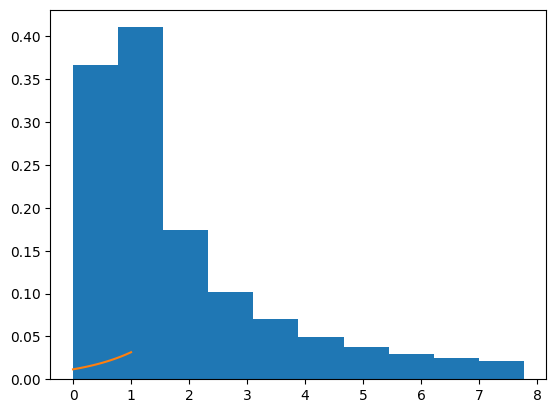

In [62]:

NUM_SAMPLES = 10**5


def importance_Exp(num_samples: int, lambda_:float = 1.35183):
    importance_samples = scipy.stats.expon.rvs(scale = 1/lambda_, size=num_samples)

    importance_h = importance_samples < 1 
    importance_f = np.exp(importance_samples)
    importance_g = scipy.stats.expon.pdf(importance_samples,scale = 1/lambda_)
    importance_est_samples = (importance_h * importance_f) / importance_g

    return importance_est_samples


importance_est = importance_Exp(num_samples=NUM_SAMPLES)
print(f"The estimated value: {importance_est.mean():.4f}, \t analytical solution {np.exp(1)-1:.4f}")


x = np.linspace(0,1)
plt.figure()
plt.hist(importance_est, density=True)
plt.plot(x,np.exp(x)/(np.exp(x).sum()))
plt.show()


As we can see not a lot of the samples from the exponential distribution is in the correct domaine. It would therefore make more sense to choose the importance distribution $g(x)$ with more carefully. In this case the true distribution we want to estimate is a increasing function and the importance distribution is decreasing in the same interval.  

## Ex09
For the pareto distribution $X \sim \text{Pareto}(k,\beta)$ the first monent is given by  $Y = \mathbb{E}[X]=\frac{k}{k-1}\beta$ where $k>1$. The first moment is also a pareto distribution with parameter $Y \sim \text{pareto}(k-1,\beta)$. If we want to estimate the mean with importance sampling we would get that $h(y) = y$. The pdf for the pareto distribution is $f(x)=\frac{k}{x}\left(\frac{\beta}{x}\right)^{k}$, which is found by differentiating the given CDF for the pareto. The term for the importance sampling then becomes

$$
\begin{align*}
\frac{h(Y)f(Y)}{g(x)} = \frac{Y \frac{k}{Y}\left(\frac{\beta}{Y}\right)^{k}}{\frac{k-1}{Y}\left(\frac{\beta}{Y}\right)^{k-1}} \\
                      = \frac{k}{k-1}\beta
                      = \mathbb{E}[X]
\end{align*}
$$
This is the mean itself, meaning importance sampling would not make sense in this case. 